**Experiment #4**

**Open question: is AUC ROC a suitable metric for early stopping in gradient-boosted decision tree libraries, or can it be replaced by AUC PR? Let's use an unbalanced dataset with CatBoost and XGBoost to test this hypothesis.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Charter'
rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 12
rcParams['axes.labelpad'] = 12
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 12
rcParams['ytick.labelsize'] = 11
rcParams['xtick.labelsize'] = 11
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.datasets import make_classification
import time
import json

In [2]:
from numpy import __version__
print('numpy: {}'.format(__version__))
from sklearn import __version__
print('sklearn: {}'.format(__version__))
from catboost import __version__
print('catboost: {}'.format(__version__))
from xgboost import __version__
print('xgboost: {}'.format(__version__))

numpy: 1.24.1
sklearn: 1.2.0
catboost: 1.1.1
xgboost: 1.7.2


In [3]:
y_hat, y_true = make_classification(
    n_samples=50_000_000,
    n_features=1,
    n_informative=1,
    n_redundant=0,
    n_repeated=0,
    n_clusters_per_class=1,
    n_classes=2,
    weights=(0.9995, 0.0005), class_sep=0.5, flip_y=0.0001,
    random_state=0)

In [4]:
df = pd.DataFrame({'data': y_hat.ravel(), 'label': y_true})
df.head()

,data,label
0,1.327996,0
1,-0.654418,0
2,0.975437,0
3,-0.618597,0
4,-1.109207,0


In [5]:
df.label.value_counts(normalize=True) * 100

label
0    99.94501
1     0.05499
Name: proportion, dtype: float64

In [6]:
roc_auc_score(df.label, df.data)

0.7838850716549493

In [7]:
average_precision_score(df.label, df.data)

0.0032325575659300767

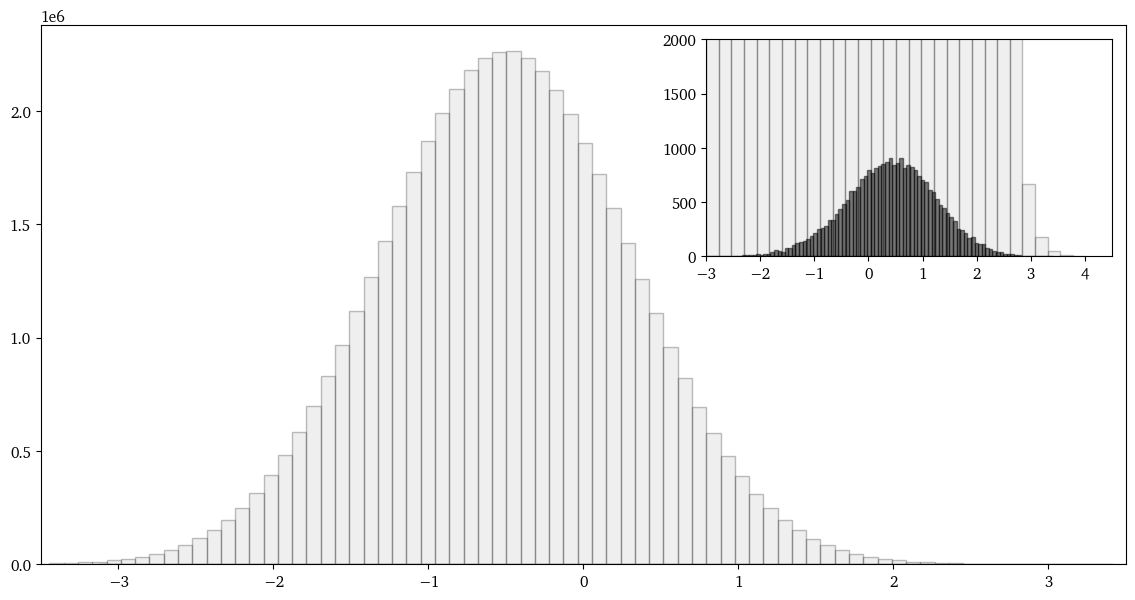

In [8]:
plt.figure(figsize=(14, 7))
_ = plt.hist(df[df.label == 0].data, bins=99, edgecolor='black', color='silver', alpha=0.25)
_ = plt.hist(df[df.label == 1].data, bins=99, edgecolor='black', color='orange', alpha=0.5)
_ = plt.xlim([-3.5, 3.5])
_ = plt.axes([0.60, 0.55, .29, .31])
_ = plt.hist(df[df.label == 0].data, bins=39, edgecolor='black', color='silver', alpha=0.25)
_ = plt.hist(df[df.label == 1].data, bins=99, edgecolor='black', color='black', alpha=0.5)
_ = plt.ylim([0, 2000])
_ = plt.xlim([-3, 4.5])

# Model quality metrics

In [9]:
from scipy.stats import f_oneway

## CatBoost

In [10]:
m1 = json.load(open('artifacts/catboost-AUC.json', 'r'))
m2 = json.load(open('artifacts/catboost-PRAUC.json', 'r'))
m3 = json.load(open('artifacts/catboost-Logloss.json', 'r'))

In [11]:
metric = 'AUC ROC'
f_oneway(m1[metric], m2[metric], m3[metric])

F_onewayResult(statistic=1.014580771784754, pvalue=0.3690072282846025)

In [12]:
metric = 'AUC PR'
f_oneway(m1[metric], m2[metric], m3[metric])

F_onewayResult(statistic=1.7455611452846287, pvalue=0.18374756329975184)

In [13]:
def plot_boxplots(out1, out2, out3):
    figure, axis = plt.subplots(1, 2, figsize=(14, 7))
    #
    for idx, metric in zip(range(2), ('AUC ROC', 'AUC PR')):
        axis[idx].boxplot(
            [
                out1[metric],
                out2[metric],
                out3[metric]
            ], medianprops={'color': 'grey'}
        )
        axis[idx].grid(True, alpha=0.3, aa=True, ls=':', lw=1.1)
        axis[idx].set_ylabel(metric)
        axis[idx].set_xlabel('Evaluation metric')
        _ = axis[idx].set_xticklabels(['AUC', 'PRAUC', 'Logloss'])
    plt.tight_layout(pad=2)

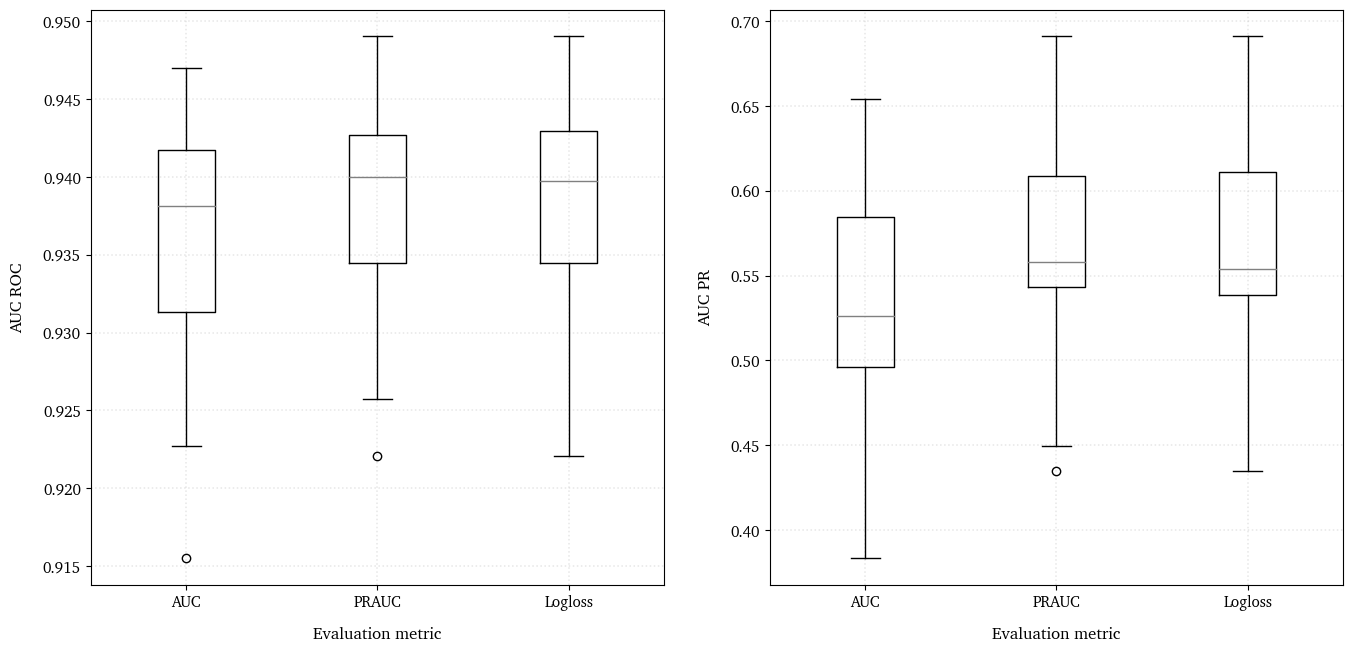

In [14]:
plot_boxplots(m1, m2, m3)
plt.savefig('figures/fig16.png', dpi=300)

## XGBoost

In [15]:
m1 = json.load(open('artifacts/xgboost-auc.json', 'r'))
m2 = json.load(open('artifacts/xgboost-aucpr.json', 'r'))
m3 = json.load(open('artifacts/xgboost-logloss.json', 'r'))

In [16]:
metric = 'AUC ROC'
f_oneway(m1[metric], m2[metric], m3[metric])

F_onewayResult(statistic=0.011057689844627492, pvalue=0.9890053426831835)

In [17]:
metric = 'AUC PR'
f_oneway(m1[metric], m2[metric], m3[metric])

F_onewayResult(statistic=0.3356178839536168, pvalue=0.716299335506857)

In [18]:
def plot_boxplots(out1, out2, out3):
    figure, axis = plt.subplots(1, 2, figsize=(14, 7))
    #
    for idx, metric in zip(range(2), ('AUC ROC', 'AUC PR')):
        axis[idx].boxplot(
            [
                out1[metric],
                out2[metric],
                out3[metric]
            ], medianprops={'color': 'grey'}
        )
        axis[idx].grid(True, alpha=0.3, aa=True, ls=':', lw=1.1)
        axis[idx].set_ylabel(metric)
        axis[idx].set_xlabel('Evaluation metric')
        _ = axis[idx].set_xticklabels(['auc', 'aucpr', 'logloss'])
    plt.tight_layout(pad=2)

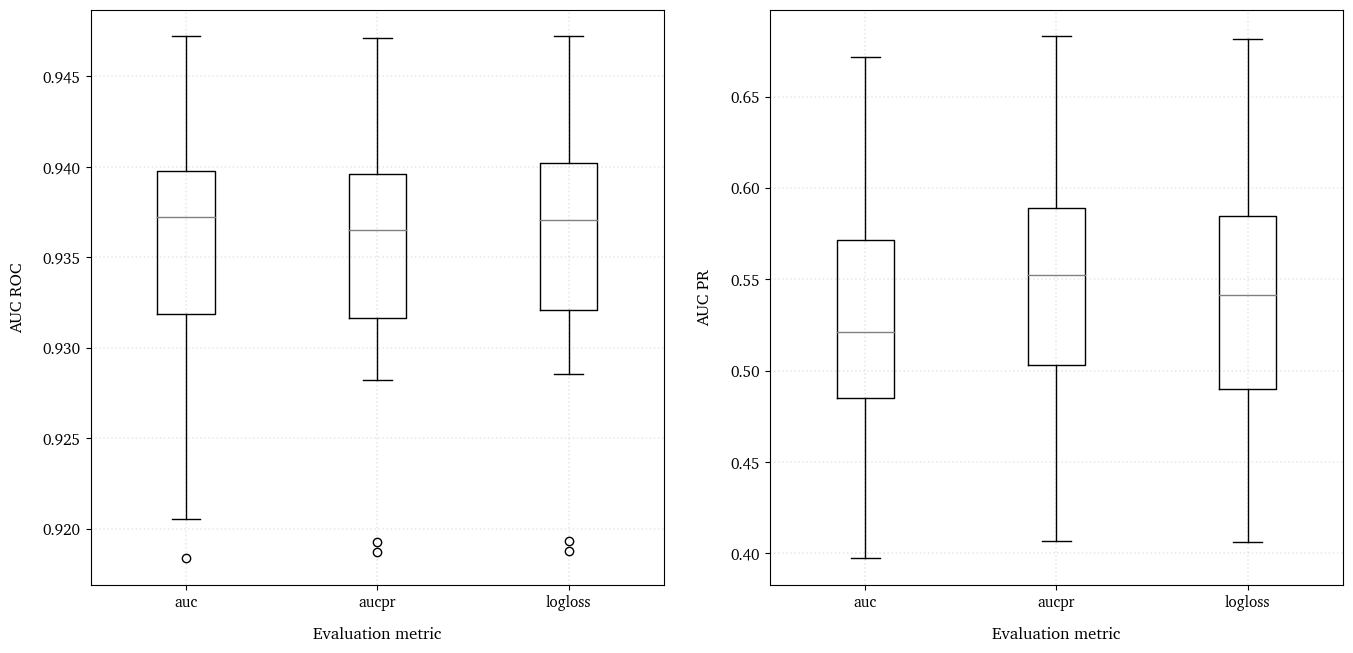

In [19]:
plot_boxplots(m1, m2, m3)